## Coursera Data Analysis
In this analysis, we will work with a dataset on online course data from Coursera. Coursera is a website on which you can purchase and follow online courses on a large variety of topics. Features in this dataset range from course title, level, provider, to features indicating the popularity of the course.

This dataset is not provided by Coursera itself, but was scraped from the Coursera website by an individual for a project in which several online educational websites were scraped. With the scraped data, the aim was to build a recommendation tool to help new learners to choose the right course for them.
<br>

More information about the way the data was scraped and about the dataset's origin can be found here: https://www.kaggle.com/datasets/siddharthm1698/coursera-course-dataset.
<br>

The aim of this analysis is to get more insighst into what makes a course popular. In other words, which courses are popular and what are typical features of a popular course? Where we define popular in terms of amount of student enrollments.
Note however that this analysis is descriptive/exploratory. We did not perform any statistical analysis, therefore we cannot draw any conclusions in terms of predictor variables here. One limitation is that we do not have many different course features in our dataset that allow us to investigate why specific courses would be more popular.

This Notebook is organised into 4 main sections:
* Data Preparation
* Exploratory Analysis
* Summary of findings
* Limitations & suggestions for further research





## Data Preparation

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Ignore all warning messages
warnings.filterwarnings('ignore')

In [ ]:
# Set graph style and colour for the entire notebook
sns.set_style('white')
sns.set_palette("crest")

In [ ]:
# Disable scientific notification in the entire notebook
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Display floats only with 2 decimals in the entire notebook
pd.options.display.float_format = '{:,.2f}'.format

In [ ]:
# Import dataset and check shape
coursera = pd.read_csv("/content/drive/MyDrive/Csv's for colab/coursea_data.csv")
print('There are {} rows and {} columns in the coursera dataset.' .format(coursera.shape[0], coursera.shape[1]))

There are 891 rows and 7 columns in the coursera dataset.


In [ ]:
coursera.head()

,Unnamed: 0,course_title,course_organization,course_Certificate_type,course_rating,course_difficulty,course_students_enrolled
0,134,(ISC)² Systems Security Certified Practitioner...,(ISC)²,SPECIALIZATION,4.70,Beginner,5.3k
1,743,A Crash Course in Causality: Inferring Causal...,University of Pennsylvania,COURSE,4.70,Intermediate,17k
2,874,A Crash Course in Data Science,Johns Hopkins University,COURSE,4.50,Mixed,130k
3,413,A Law Student's Toolkit,Yale University,COURSE,4.70,Mixed,91k
4,635,A Life of Happiness and Fulfillment,Indian School of Business,COURSE,4.80,Mixed,320k


* When printing the first few rows, we notice that the first feature has a name "Unnamed: 0", which doesn't tell us anything about the data in this column. It seems to exist of numbers, thus in case the values are unique, this might serve as a unique identifier.
* All feature names start with 'course_', we can leave this out to make feature names quicker to interpret, as we know that it's about courses.
* Furthermore, the course_students_enrolled feature includes 'k' in the values, assumingly for thousands, instead of zeros. Because of these letters it will probably be of string data type, while if we want to calculate statistics and create plots to look at the spread, we will need it to be numeric.

In [ ]:
# Check whether the first column "Unnamed: 0" could serve as a unique identifier
column_1 = coursera.iloc[:, 0]
column_1_unique = column_1.nunique()
print('There are {} unique values for the column "Unnamed: 0", equal to the amount of cases in the dataset.'
.format(column_1_unique))

There are 891 unique values for the column "Unnamed: 0", equal to the amount of cases in the dataset.


In [ ]:
# Rename the first column "Unnamed: 0" into "id"
coursera = coursera.rename(columns={"Unnamed: 0": "id"})

In [ ]:
# Take out 'course_' from the feature names and make them all lowercase
coursera.columns = coursera.columns.str.replace(r'^course_', '', regex=True).str.lower()
coursera.column

Index(['id', 'title', 'organization', 'certificate_type', 'rating',
       'difficulty', 'students_enrolled'],
      dtype='object')

In [ ]:
# Check the feature's data types and missing values
coursera.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 891 non-null    int64  
 1   title              891 non-null    object 
 2   organization       891 non-null    object 
 3   certificate_type   891 non-null    object 
 4   rating             891 non-null    float64
 5   difficulty         891 non-null    object 
 6   students_enrolled  891 non-null    object 
dtypes: float64(1), int64(1), object(5)
memory usage: 48.9+ KB


We find out that two features are numeric, one of which the first column. Five features are of string/object type. We notice that the students_enrolled feature is as expected, of object type, which we will thus need to clean and change into numeric.

There are no missing values.

Next we will check for duplicate cases, both for full duplicates and duplicates in the course title column, as this is the only feature for which duplicate values could be an issue. Duplicates in ratings, difficulty, organisation etc are realistic.

In [ ]:
# Check for full duplicates and duplicates in the title column
full_duplicates = coursera.duplicated().sum()
title_duplicates = coursera.duplicated("title").sum()
print('There are',full_duplicates,'fully duplicated cases, but', title_duplicates,'duplicate titles')

There are 0 fully duplicated cases, but 3 duplicate titles


In [ ]:
# Filter out the duplicated title rows and compare them on their categorical feature values
duplicate_rows = coursera[coursera.duplicated('title', keep=False)]
duplicate_rows[["title", "organization", "certificate_type", "difficulty"]]

,title,organization,certificate_type,difficulty
224,Developing Your Musicianship,Berklee College of Music,COURSE,Mixed
225,Developing Your Musicianship,Berklee College of Music,SPECIALIZATION,Beginner
563,Machine Learning,University of Washington,SPECIALIZATION,Intermediate
564,Machine Learning,Stanford University,COURSE,Mixed
582,Marketing Digital,Universidade de São Paulo,COURSE,Beginner
583,Marketing Digital,Universidad Austral,SPECIALIZATION,Beginner


As we see, the 3 duplicate titled courses seem to either be offered by different universities and/or of different difficulty levels, and have different certificate types. Thus, we will treat these as different courses and not leave out any cases based on this.

Next we will clean up the students_enrolled variable, by taking out the string characters.

In [ ]:
# For the students_enrolled feature, take out the 'k' for thousands and 'm' for millions,
# and replace with the correct amount of zeros in the students_enrolled variable
coursera["students_enrolled"] = coursera["students_enrolled"].replace({'m': '000000', 'k': '000'}, regex=True)
coursera["students_enrolled"]

0      5.3000
1       17000
2      130000
3       91000
4      320000
        ...  
886     52000
887     21000
888     30000
889    9.8000
890     38000
Name: students_enrolled, Length: 891, dtype: object

We notice there are values with a dot (.) in it, which are preventing us from converting the data type to numerical, and which furthermore will have gotten one zero too much (5.3k will become 53000 if removing .) These cases will be handled below.

In [ ]:
# Subset the dataset for the cases where students_enrolled contains a dot.
students_dot = coursera["students_enrolled"].str.contains('\.', regex=True)
subset = coursera.loc[students_dot]

# Replace . in the students_enrolled feature inside the subset,
# change data type to int to be able to divide by 10, in order to get rid of surplus zero.
subset["students_enrolled"] = subset["students_enrolled"].str.replace('\.', '', regex=True).astype(int) / 10

# Override the cases in the dataset with the modified subset values
coursera[students_dot] = subset

In [ ]:
# Convert the students_enrolled feature of the entire dataset to integer data type
coursera["students_enrolled"] = coursera["students_enrolled"].astype(int)
coursera["students_enrolled"]

0        5300
1       17000
2      130000
3       91000
4      320000
        ...  
886     52000
887     21000
888     30000
889      9800
890     38000
Name: students_enrolled, Length: 891, dtype: int64

We can see from the output above that the student_enrolled feature is now of integer data type, comparing with the head printed earlier, the values seem correct. Below we take a look at the spread of the numerical variables in the dataset.  




In [ ]:
# Check the distributions of the numerical features
coursera[["rating", "students_enrolled"]].describe()

,rating,students_enrolled
count,891.00,891.00
mean,4.68,"90,552.08"
std,0.16,"181,936.45"
min,3.30,"1,500.00"
25%,4.60,"17,500.00"
50%,4.70,"42,000.00"
75%,4.80,"99,500.00"
max,5.00,"3,200,000.00"


* For students_enrolled, the range seems very large, and especially the max of 3.2 million is much further from the median of 42000 than the minimum. However, logically it is possible that some courses are much more popular than others.
* The mean is closer to the 75% percentile than to the median. Also, the standard deviation is about twice the mean. We can see in the boxplot below that the distribution suffers from a lot of outliers.

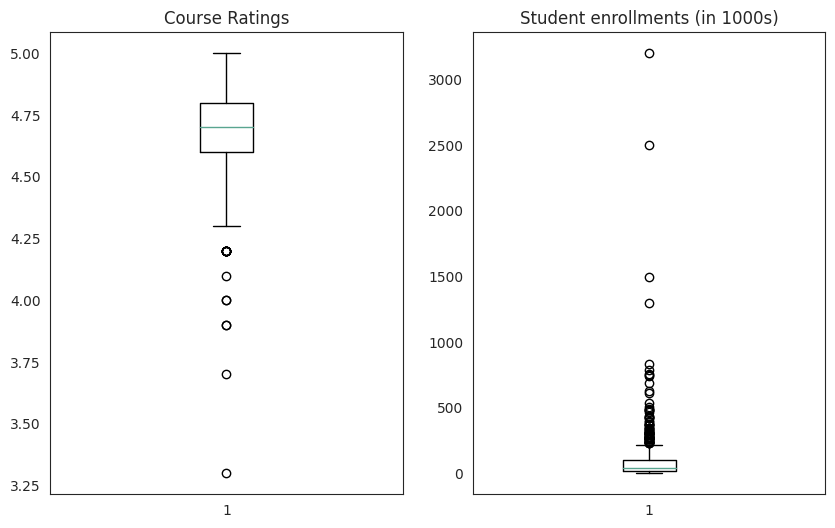

In [ ]:
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
box = plt.boxplot(coursera["rating"])
plt.title("Course Ratings")
# Calculate the students_enrolled feature in thousands, to make the plot easier to interpret
coursera["students_enrolled_thousands"] = coursera["students_enrolled"]/1000
plt.subplot(1,2,2)
box2 = plt.boxplot(coursera["students_enrolled_thousands"])
plt.title("Student enrollments (in 1000s)");


The boxplots seem to show completely opposite patterns, the rating distribution is left-skewed, while the student_enrolled is right-skewed.

* When looking at the distribution of the ratings, what is standing out is the mean of 4.67 is very high since the possible range is 0 to 5.
* Rating mean and median don't seem very far apart, also the standard distribution seems very small.
* The minimum seems pretty far from the 1st quartile, thus it seems like a few courses were more poorly rated and causing this tail in the distribution. However, a minimum of about 3.25 is also not low considering the possible range of 0 to 5. We might wonder if Coursera is getting rid of courses with a relatively low rating quickly, in order to keep their average high?
* A limitation here is that our data consists of average ratings per course, we do not have information on the amount of individual ratings these averages are based on. This means some courses might be having a rating that was based on a lot of individual ratings while others might just be based on a few. Furthermore, the rating distribution mean above is an average of averages.


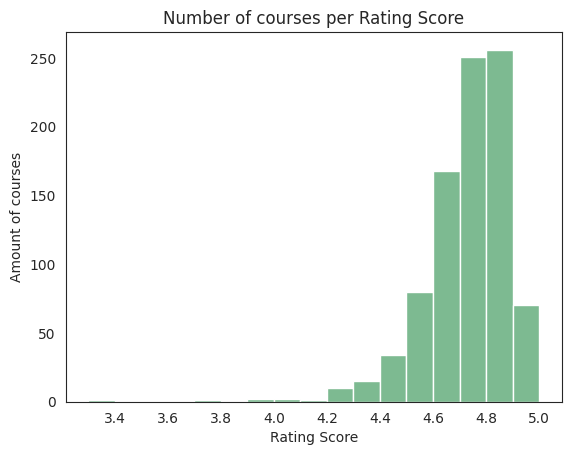

In [ ]:
# plot the distribution of the ratings with 17 bins to have one bin per 0.1 step
plt.hist(coursera["rating"], bins=17)
xticks = np.arange(3.4, 5.2, 0.2)
plt.title("Number of courses per Rating Score")
plt.xticks(xticks)
plt.xlabel("Rating Score")
plt.ylabel("Amount of courses");

The students_enrolled boxplot is very hard to interpret, apart from that it seems like there are clear outliers. We will now calculate the amount of outliers, recalling the definition of an outlier is a datapoint that lies 1,5 interquartile range from the first or third quartile, with the IQR being the difference between the first and third quartiles.

We will then filter out the outliers and re-plot the distribution.

In [ ]:
# Calculate interquartile range and minimum and maximum allowed distance from iqr
IQR = 99500 - 17500
upper_value = 99500 + 1.5*IQR
lower_value = 17500 - 1.5*IQR
print('The lower range is:',lower_value,'\nThe upper range is:', upper_value,)

The lower range is: -105500.0 
The upper range is: 222500.0


In [ ]:
# Create a subset without outliers and check the spread of the outlier_free distribution
outlier_free = coursera[coursera["students_enrolled_thousands"] < 222.5]
outlier_free["students_enrolled"].describe()

count       813.00
mean     55,143.79
std      51,692.89
min       1,500.00
25%      16,000.00
50%      37,000.00
75%      78,000.00
max     220,000.00
Name: students_enrolled, dtype: float64

* We have 813 cases left after taking out outliers, thus 78 cases were taken out.
* The mean and median are now closer to each other, and the standard deviation is lower than the mean itself. However, the distribution is still heavily right-skewed, as can be seen in the boxplot and histogram below, values still seem concentrated on the lower side.
* When re-calculating IQR and upper range over the new distribution, the max is again an outlier (Q3 + IQR * 1.5 (78 + (78-16)* 1.5 = 171), while max is 220), which we can clearly see in the histogram below, and likely a few values just below it as well.

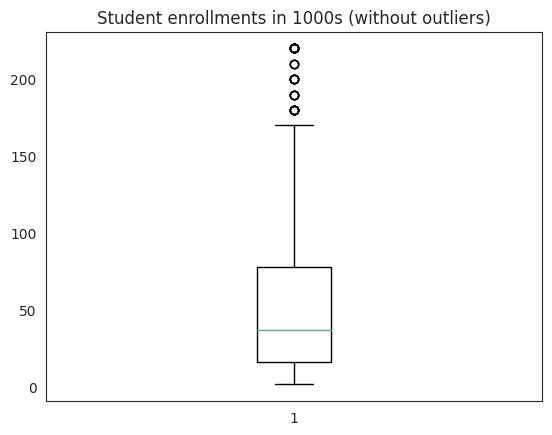

In [ ]:
plt.boxplot(outlier_free["students_enrolled_thousands"])
plt.title("Student enrollments in 1000s (without outliers)");

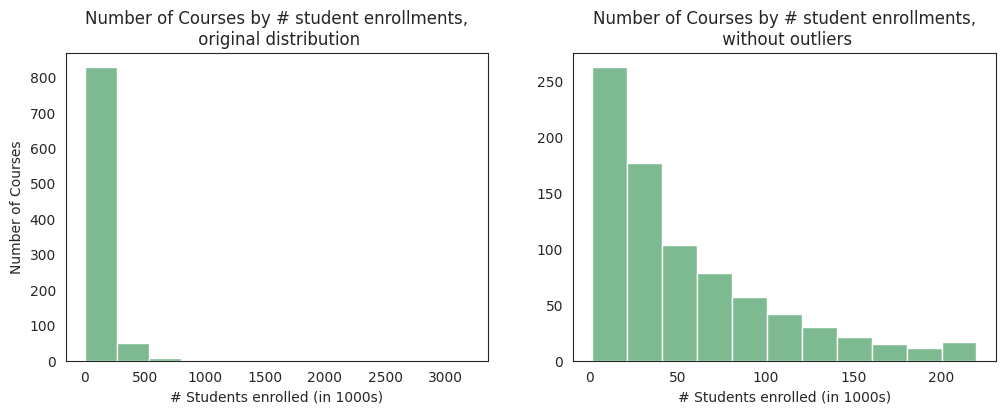

In [ ]:
# Create a histogram of both the original and outlier free distributions,
# adjust binsize to a number divisible by the range to improve interpretability
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.hist(coursera["students_enrolled_thousands"], bins=12)
plt.title("Number of Courses by # student enrollments,\n original distribution")
plt.xlabel("# Students enrolled (in 1000s)")
plt.ylabel("Number of Courses")

plt.subplot(1, 2, 2)
plt.hist(outlier_free["students_enrolled_thousands"], bins=11)
plt.title("Number of Courses by # student enrollments,\n without outliers")
plt.xlabel("# Students enrolled (in 1000s)")
plt.ylabel("");

* The distribution remains skewed. We will not leave out any cases here, as the purpose of this analysis is exploratory and we do not plan to do any modelling with the data, thus we do not have to worry about the normal distribution assumption that most models make.
* Plus we aim to find out what makes a course popular, thus by taking out the most popular ones we might be taking out the most valueable information for answering our research question.
* Note that for most distributions we will look at median instead of mean to get an idea of where most values are centered, as the mean will be influenced by outliers and therefore not give an accurate view, while the median does not suffer from this.

Now we will take a closer look at the string type features. First we take a look at the categories of course 'difficulty' and 'certification type'.

In [ ]:
# For the certificate_type features, make all values capitalised first letter instead of uppercase,
# in line with the other features in the dataset
coursera["certificate_type"] = coursera["certificate_type"].str.title()

# Check which levels exist for difficulty and certificate_type
certification_levels = list(coursera["certificate_type"].unique())
difficulty_levels = coursera["difficulty"].unique()
print('The levels of difficulty are {}'.format(difficulty_levels))
print('The different types of certificates are {}'.format(certification_levels))

The levels of difficulty are ['Beginner' 'Intermediate' 'Mixed' 'Advanced']
The different types of certificates are ['Specialization', 'Course', 'Professional Certificate']


It turns out there are four categories for course difficulty, which seem to have a clear order except for the 'Mixed' value, of which I am not sure how to interpret this. This makes me curious how common this value is, in case it is very uncommon we could leave it out and might choose to make this column numerical for the purpose of calculating average difficulty.
Except for the above, the category levels of difficulty and certificate_type seem to intuitively make sense and do not contain any inconsistencies.

Next we take a closer look at the values in the 'title' and 'organization' variables, to make sure there are no out of range or inconsistent entries there.

In [ ]:
coursera["organization"].unique()

array(['(ISC)²', 'University of Pennsylvania', 'Johns Hopkins University',
       'Yale University', 'Indian School of Business',
       'University at Buffalo', 'deeplearning.ai', 'IBM',
       'Amazon Web Services', 'University of Toronto',
       'University of California, Irvine',
       'University of Illinois at Urbana-Champaign',
       'University of Michigan',
       'Universidad Nacional Autónoma de México',
       'University of Colorado Boulder',
       'National Research University Higher School of Economics',
       'Google Cloud', 'Erasmus University Rotterdam', 'Duke University',
       'University of Virginia', 'Atlassian', 'ScrumTrek',
       'University of California San Diego', 'Stanford University',
       'University of Colorado System', 'Copenhagen Business School',
       'Macquarie University', 'Vanderbilt University',
       'The University of Edinburgh',
       'Technical University of Denmark (DTU)', 'Universidad Austral',
       'Arizona State University', 

After a quick scan, there do not seem to be any values with encoding errors or strange signs, no capitalisation errors or other abnormalities.  

We can see there are a lot of universities, but also some company names. There are names in other languages than English, however since the organisation and title features are of object type, this is not a problem.


## Exploratory Analysis

### Course popularity

* How many courses are there in total and how many students in total are enrolled to courses? What is the average per course?
* Which courses are most popular in terms of amount of students enrolled to them?

In [ ]:
Amount_courses = coursera["id"].nunique()
Amount_students = coursera["students_enrolled"].sum()
Avg_students = (Amount_students / Amount_courses).astype(int)
print('There are {} courses offered on the Coursera website,\n'
'and there are {} million students enrolled in total, thus {} on average per course.'.format(Amount_courses, (Amount_students / 1000000).round(1), Avg_students))

There are 891 courses offered on the Coursera website,
and there are 80.7 million students enrolled in total, thus 90552 on average per course.


In [ ]:
# Courses organised by number of students_enrolled, descending.
coursera[["title", "organization", "rating", "students_enrolled"]].sort_values("students_enrolled", ascending=False).head(15)

,title,organization,rating,students_enrolled
564,Machine Learning,Stanford University,4.90,3200000
815,The Science of Well-Being,Yale University,4.90,2500000
688,Python for Everybody,University of Michigan,4.80,1500000
674,Programming for Everybody (Getting Started wit...,University of Michigan,4.80,1300000
196,Data Science,Johns Hopkins University,4.50,830000
129,Career Success,"University of California, Irvine",4.40,790000
261,English for Career Development,University of Pennsylvania,4.80,760000
765,Successful Negotiation: Essential Strategies a...,University of Michigan,4.80,750000
199,Data Science: Foundations using R,Johns Hopkins University,4.60,740000
211,Deep Learning,deeplearning.ai,4.80,690000


It seems that the 'Machine Learning' course of Stanford University is most popular with 3.2 million students enrolled.
The 4 most popular courses each have more than a million students enrolled.

Recalling the average of all the course ratings (which are in itself already averages) is 4.68, it seems like most popular courses have an overaverage rating except for just a few. Thus we might wonder whether the rating is something students take into account when choosing a course.

### Ratings

* Which courses on Coursera are rated highest? Are these the same as the most popular ones in terms of students enrolled?
* Is there a correlation between rating and amount of students enrolled?

In [ ]:
coursera[["title", "organization", "rating", "students_enrolled"]].sort_values("rating", ascending=False).head(15)

,title,organization,rating,students_enrolled
251,El Abogado del Futuro: Legaltech y la Transfor...,Universidad Austral,5.00,1500
432,Infectious Disease Modelling,Imperial College London,5.00,1600
754,Stories of Infection,Stanford University,4.90,28000
290,Everyday Parenting: The ABCs of Child Rearing,Yale University,4.90,86000
98,Boosting Creativity for Innovation,HEC Paris,4.90,9500
99,"Brand Management: Aligning Business, Brand and...",London Business School,4.90,57000
614,More Introduction to Financial Accounting,University of Pennsylvania,4.90,40000
102,Bugs 101: Insect-Human Interactions,University of Alberta,4.90,15000
836,Understanding Einstein: The Special Theory of ...,Stanford University,4.90,89000
103,Build a Modern Computer from First Principles:...,Hebrew University of Jerusalem,4.90,95000


* We can see that the courses with most students enrolled are not among the highest rated. The highest rated courses are actually very low in terms of students enrolled. Thus, we might wonder if this 5 star rating was based only on a relatively small amount of ratings, and whether the rating will go down once a lot more students will have rated it. The number 3 and 4 courses with highest rating do have a fair amount of student enrollments and thus might be based on a lot more ratings. We can see that those are provided by the organisations that also provide the courses with highest amounts of student enrollments.

* What is also standing out is that among the top 15 courses with most students enrolled, many were related to data science, while the top rated 15 ones are on a broader variety of topics.

* The organisations providing them are in both cases mostly universities.

* We might still wonder whether rating and amount of students_enrolled are correlated as the courses with highest number of enrollments are all rating high.

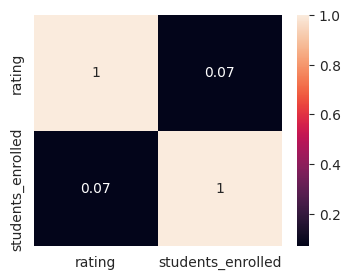

In [ ]:
# Calculate correlations between rating and students enrolled
numerical_columns = coursera[["rating", "students_enrolled"]]
plt.figure(figsize=(4,3))
corr_matrix = numerical_columns.corr().round(2)
sns.heatmap(corr_matrix, annot=True);


The rating and students_enrolled features turn out not to be correlated. Thus if for example rating is high, there is no consistency in whether the amount of enrolled students will be high or low, and the same the other way around.

### Difficulty

* How many courses are there for each level of difficulty? Which % does each level make up?
* How many students are enrolled per level?
* Are the levels differing in their average amounts of students enrolled per course?  



In [ ]:
# Check the amount of courses per level of difficulty
difficulty_distribution = coursera.groupby("difficulty")[["id"]].count().rename(columns={"id":"nr_courses"})
# Calculate percentages
difficulty_distribution["%of_courses"] = (difficulty_distribution["nr_courses"] / 891 *100)
difficulty_distribution.sort_values("nr_courses", ascending=False)

,nr_courses,%of_courses
difficulty,,
Beginner,487,54.66
Intermediate,198,22.22
Mixed,187,20.99
Advanced,19,2.13


There are clearly a lot more beginner level courses than any other level. In fact, more than half of the courses in the dataset are of beginner level, and only 2% of courses are of advanced level.

Now we wonder to which course level most students enroll.

In [ ]:
# Check the amount of students enrolled per level of difficulty
students_level = coursera.groupby("difficulty")[["students_enrolled_thousands"]].sum().astype(int)
# Calculate percentages
students_level["%of_students"] = (students_level["students_enrolled_thousands"] / Amount_students * 100000)
students_level.rename(columns={"students_enrolled_thousands": "student enrollments (in 1000s)"}).sort_values("student enrollments (in 1000s)", ascending=False)

,student enrollments (in 1000s),%of_students
difficulty,,
Beginner,39921,49.48
Mixed,24989,30.97
Intermediate,14506,17.98
Advanced,1264,1.57


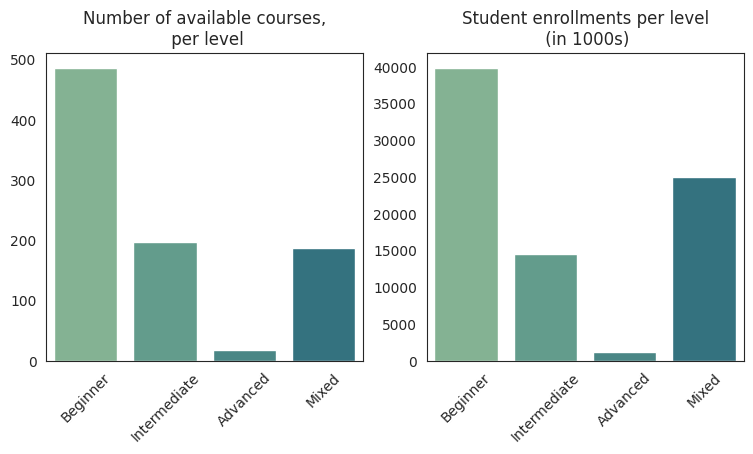

In [ ]:
# Create a bar plot for amount of courses per level
plt.figure(figsize=(9,4))
category_order = ["Beginner", "Intermediate", "Advanced", "Mixed"]
plt.subplot(1,2,1)
plt.title("Number of available courses,\n per level")
ax = sns.barplot(x=difficulty_distribution.index, y=difficulty_distribution["nr_courses"], order=category_order)
ax.set_ylabel('')
ax.set_xlabel('')
plt.xticks(rotation=45)
# Create the bar plot for student enrollments
plt.subplot(1,2,2)
plt.title("Student enrollments per level\n (in 1000s)")
ax1 = sns.barplot(x=students_level.index, y=students_level["students_enrolled_thousands"], order=category_order)
ax1.set_ylabel('')
ax1.set_xlabel('')
plt.xticks(rotation=45);

* The distributions look very similar, a little less than half of the enrollments are for beginner courses, while a little more than 50% of courses are of beginner level.
* Just 1.5% of enrollments is for advanced level courses, which make up 2% of the course portfolio.   
* The only level that seems to differ in relative number between the two distributions is the mixed type. 30% of enrollments are for mixed level, while 21% of the courses is of mixed level. Thus, this level will likely have a higher average amount of students per course.

In [ ]:
# Merge above 2 tables to be able to calculate average number of enrollments course,
# for each level of difficulty
merged_difficulty = pd.merge(students_level, difficulty_distribution, on="difficulty")
merged_difficulty["Avg_students_level"] = merged_difficulty["students_enrolled_thousands"] / merged_difficulty["nr_courses"]
merged_difficulty.rename(columns={"students_enrolled_thousands": "student enrollments (in 1000s)", "Avg_students_level": "Avg # students per course"})

,student enrollments (in 1000s),%of_students,nr_courses,%of_courses,Avg # students per course
difficulty,,,,,
Advanced,1264,1.57,19,2.13,66.53
Beginner,39921,49.48,487,54.66,81.97
Intermediate,14506,17.98,198,22.22,73.26
Mixed,24989,30.97,187,20.99,133.63


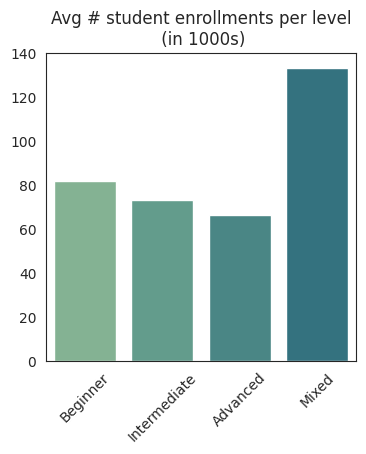

In [ ]:
plt.figure(figsize=(4,4))
plt.title("Avg # student enrollments per level\n (in 1000s)")
sns.barplot(x=merged_difficulty.index, y=merged_difficulty["Avg_students_level"], order=category_order)
plt.ylabel('')
plt.xlabel('')
plt.xticks(rotation=45);

As expected, the mixed level has by far the highest amount of enrollments per course of 134, while the advanced level has only about half the amount of enrollemts per course, 67.
This information would be valuable when investigating course monetisation, which could be a goal of follow up research.

### Certification type

* How many courses are there for each certification type?
* How many students are enrolled per certification type?

In [ ]:
# Group by certificate type variable and count distinct values
certification_types = coursera.groupby("certificate_type")[["id"]].nunique().sort_values("id", ascending=False).rename(columns={"id": "nr_courses"})
# Calculate percentages
certification_types["%of_courses"] = (certification_types["nr_courses"] / 891 *100)
certification_types.sort_values("nr_courses", ascending=False)

,nr_courses,%of_courses
certificate_type,,
Course,582,65.32
Specialization,297,33.33
Professional Certificate,12,1.35


Most courses are desribed as 'course', there is still a relatively large amount of specialisations, and only a very small amount of Professional Certificates.

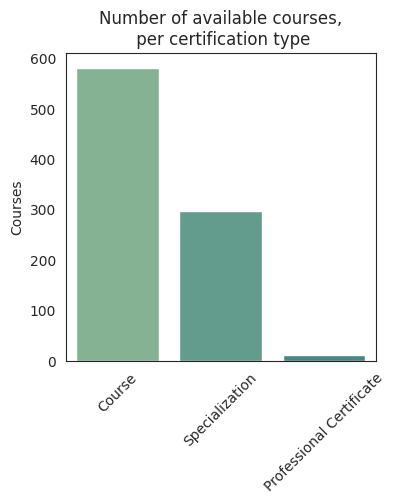

In [ ]:
plt.figure(figsize=(4,4))
plt.title("Number of available courses,\n per certification type")
ax = sns.barplot(x=certification_types.index, y=certification_types["nr_courses"])
ax.set_ylabel('Courses')
ax.set_xlabel('')
plt.xticks(rotation=45);

### Organisations
* How many organisations are providing courses on Coursera?
* Which organisations provide most courses, what is the average and how spread is this?
* Which organisations have most student enrollments, and how spread is this?
* Which organisations are having the highest average amounts of students per course? How spread is this?
* Are specific organisations providing specific types of certificates?




In [ ]:
nr_organisations = coursera["organization"].nunique()
print('There are' ,nr_organisations, 'organisations in total, together providing', Amount_courses, 'courses on the Coursera website.')

There are 154 organisations in total, together providing 891 courses on the Coursera website.


#### Course portfolio

In [ ]:
# Count amount of courses per organisation
courses_by_org = coursera.groupby("organization")[["id"]].count().sort_values("id", ascending=False).rename(columns={"id":"nr_courses"})
courses_by_org.head(10)

,nr_courses
organization,
University of Pennsylvania,59
University of Michigan,41
Google Cloud,34
Duke University,28
Johns Hopkins University,28
"University of California, Irvine",27
University of Illinois at Urbana-Champaign,22
IBM,22
"University of California, Davis",21


In terms of organisation type, it seems to be mainly American Universities that are among the largest providers, and a few multinationals.  

The highest number of courses provided by one organisation is 59, while the second is almost already providing 20 courses less. It turns out there are 9 course providers that provide more than 20 courses. This will probably give us a right-skewed distribution, with a lot of organisations providing a relatively small amount of courses.

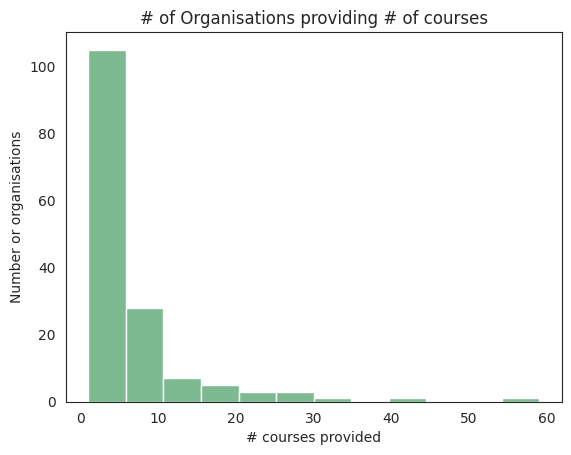

In [ ]:
plt.hist(courses_by_org, bins=12)
plt.title("# of Organisations providing # of courses")
plt.xlabel('# courses provided')
plt.ylabel('Number or organisations');

Most organisations (over a 100) are providing 1 to 5 courses on Coursera. The organisations providing most courses are clearly outliers.

We might want to know how many organisations are providing just one course, and whether this is the majority.
Also we can look at the median to see how many courses most organisations roughly provide. Since our distribution is skewed, the mean is distorted by outliers.

In [ ]:
one_course_providers = (courses_by_org["nr_courses"] == 1).sum()
median_courses_provided = courses_by_org["nr_courses"].median().astype(int)
print('There are {} organisations providing only 1 course,\n'
'which is about 33% of the organisations in the dataset. The median amount of courses provided per organisation is {}.' .format(one_course_providers, median_courses_provided))

There are 49 organisations providing only 1 course,
which is about 33% of the organisations in the dataset. The median amount of courses provided per organisation is 3.


Now we might wonder which organisations are most popular to follow a course with, and whether the organisations with most courses also have most student enrollments.  

#### Student enrollments

In [ ]:
students_by_org = coursera.groupby("organization")[["students_enrolled"]].sum()
students_by_org.sort_values("students_enrolled", ascending=False).head(10)

,students_enrolled
organization,
University of Michigan,7437700
University of Pennsylvania,5501300
Stanford University,4854000
"University of California, Irvine",4326000
Johns Hopkins University,4298900
Duke University,3967600
Yale University,3952000
IBM,2956400
deeplearning.ai,2863400


* The University of Michigan has most student enrollments, over 7 million. This is quite a big difference with the second most popular course provider, of roughly 2 million, the university of Pennsylvania. Note that the number 1 and 2 are also the number 1 and 2 highest in amount of courses provided, however with switched places. This indicates that the uni of Michigan will have a much higher average amount of students enrolled per course.
* The top 10 organisations with most students enrolled are largely overlapping with the top 10 organisations providing most courses, which intuitively makes sense.
* What else is standing out is that Google Cloud is third largest in the amount of courses it provides, but 10th when it comes to amount of students enrolled. Thus, it will likely have a relatively low average amount of student enrollments per course.

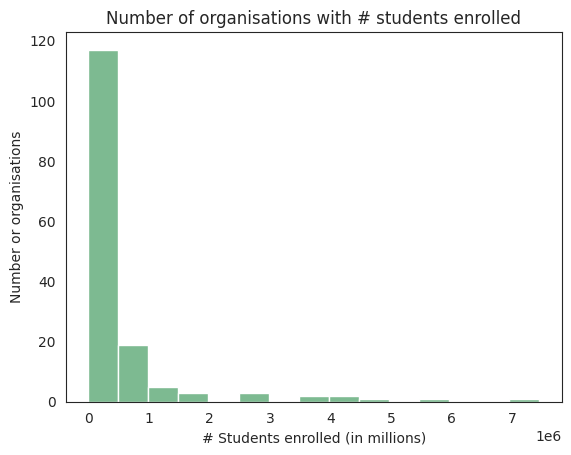

In [ ]:
plt.hist(students_by_org, bins=15)
plt.title("Number of organisations with # students enrolled")
plt.xlabel('# Students enrolled (in millions)')
plt.ylabel('Number or organisations');

To more equally compare both large and smaller organisations in terms of popularity of their courses, we could calculate and compare the average amounts of enrolled students per course.

In [ ]:
# merge above 2 data frames to easily compare organisations on the number of students
# and number of courses they provide, and calculate a new metric for the avg amount of student enrollments per course
merged_org = pd.merge(courses_by_org, students_by_org, on="organization")
merged_org["avg_students_course"] = (merged_org["students_enrolled"]/merged_org["nr_courses"]).astype(int)
# print out the top 10 organisations with highest avg amount students
merged_org[["nr_courses", "avg_students_course"]].sort_values("avg_students_course", ascending=False).head(10)

,nr_courses,avg_students_course
organization,,
Stanford University,16,303375
Yale University,17,232470
McMaster University,1,230000
Google - Spectrum Sharing,1,210000
Ludwig-Maximilians-Universität München (LMU),2,192500
École Polytechnique,1,190000
University of Michigan,41,181407
Georgia Institute of Technology,10,181300
deeplearning.ai,16,178962


This makes for a quite different top 10, the university of Michigan is still in there but slightly lower. The top is now made up of two other universities: Stanford and Yale. The numbers 3 to 6 are organizations that only provide one or two courses.

Stanford, Yale and Michigan universities, and deeplearning.ai, are present in all the top 10's.

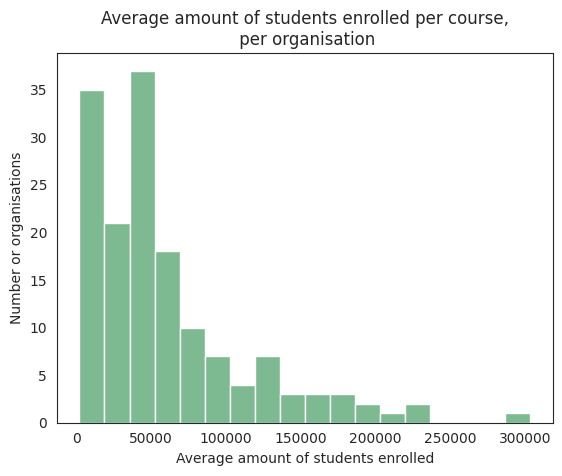

In [ ]:
plt.hist(merged_org["avg_students_course"], bins=18)
plt.title("Average amount of students enrolled per course,\n per organisation")
plt.xlabel('Average amount of students enrolled')
plt.ylabel('Number or organisations');

The distribution of average amount of students per course, per organisation is still right skewed. We can distinguish 2 slight peaks on the lower end, for the rest the distribution does not differ a whole lot from the total enrolled students per organisation distribution.

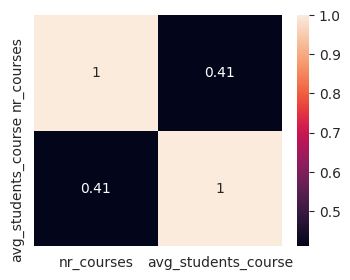

In [ ]:
# Calculate correlations between number of courses an organisation provides,
# and average amount of students enrolled per course.
plt.figure(figsize=(4,3))
corr_matrix = merged_org[["nr_courses", "avg_students_course"]].corr().round(2)
sns.heatmap(corr_matrix, annot=True);

The average amount of students enrolled per course of an organisation seems to be  moderately positively correlated with the number of courses an organisation provides. Thus, the more courses an organisation offers, the higher the average amount of students per course is likely to be, and the other way around. Note that we do not know whether one is leading to the other, as correlation does not imply causation.
What we can take from this, is that next we could hypothesize which direction this relation would be in.

#### Organisation type

Now we might wonder if it's specific types of organisations that offer most courses. In the top lists printed above, we did notice the majority are (American) universities, however there are also companies like Google, IBM and deeplearning.ai in there.

We might wonder if course popularity and rating differ between educational institutions and companies.

In [ ]:
# Filter out all organisations that have terms related to school in their name
university_courses = coursera[coursera["organization"].str.contains('School|Universi|College|Institute|École|Sciences Po')]
nr_university_courses = university_courses["id"].nunique()
nr_universities = university_courses["organization"].nunique()
relative_uni = ((nr_university_courses / 888)*100)
print('There are {} educational institutions, together providing {} courses on Coursera.' .format(nr_universities, nr_university_courses))

There are 115 educational institutions, together providing 736 courses on Coursera.


In [ ]:
# Calculate average and median ratings and amount of students enrolled by educational institutions compared to companies.
coursera['org_type'] = np.where(coursera['organization'].str.contains('School|Universi|College|Institute|École|Sciences Po', case=False), 'School', 'Company')
coursera.groupby("org_type")[["rating", "students_enrolled"]].agg([np.median, np.mean])

rating      students_enrolled          
         median mean            median      mean
org_type                                        
Company    4.70 4.66         37,000.00 84,810.32
School     4.70 4.68         43,000.00 91,761.28

Educational institutions seem to get a little higher average rating than companies, and also a higher average and median amounts of students enrolled. We are looking at both mean and median as the mentioned features have non-normal distributions.

To test whether the differences in means are significant we would need to run an independent samples t-test, however since our data is not normally distributed, this would not give us accurate results.

## Summary of findings

To answer our question of what seems to make a course popular:

Popularity:
* The most popular courses in terms of amounts of students enrolled, are provided by American universities, have an overaverage rating, and are mostly on topics related to data science.

Rating:
* Generally, most courses on the Coursera website are highly rated, just about 25% rates below the average of 4.67 (range 0-5).
* The most highly rated courses are provided by universities from around the world, and are on a broader variety of topics. These are both courses with low and high numbers of students enrolled.

Difficulty:
* Most courses on Coursera are of beginner level (54%). This level also has most student enrollments (49% of total enrollments).  
* Only 2% of courses is of advanced level, with 1.5% of student enrollments to those.
* There is a 'mixed' difficulty level of which it is unclear what it means. The 2 most popular courses are of this level. Also 31% of student enrollments are for courses of mixed level, while they make up 21% of the course portfolio. Thus, this seems a relatively popular level.

Organisational level:
* Organisations that provide the highest number of courses and have the highest total amount of student enrollments are the universities of Michigan and Pennsylvania. Both top 10's are mostly made up of American universities.
* The organisations with the highest average amount of student enrollments per course, are Yale and Stanford, and these are also the universities who provide the overall most popular courses, and the highest ranked courses with large amount of enrollments.  

Organisation type:
* University courses seem more popular in terms of average amount of enrollments per course, and rank slightly higher than courses provided by companies. However, to investigate whether these differences are significant, an independent sample t-test would be needed, which in our case will not give accurate results as our data is not normally distributed, thus this is scoped out here.  


## Limitations

This analysis is just descriptive/exploratory, thus we cannot establish causal relationships here as we did not perform any statistical analysis. We only find answers to which courses rate highest and are most popular, but we cannot say why since we only have a very small amount of features. Except for the difficulty and the course topic as derived from the name, we do not have any specific data about the content of the course itself. Features like course category, structure of the course, pricing, language options, length, user interaction with the course etc, we could have compared between courses and have investigated whether they could serve as predictors of popularity of a course.

If time range data would have been included, we could have looked at how popularity of a course or category develops over time. We might wonder how quickly after launching a course sales take up and at which speed, when popularity/sales is at its peak, and when it starts to wear off. Then also we could have investigated whether there are common patterns for this or whether adoption/sales patterns differ highly between courses/categories/organisations.